# "Concevez une application au service de la santé publique"
_Analysis Notebook_

In [1]:
from google.colab import files, drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [2]:
# May need to reboot the environment
!pip install -r "My Drive/--DATA SCIENCE/PROJET3/requirements.txt"
# !pip install modin
# !pip install modin[all]
!pip install ppscore
!pip install mlxtend

Ignoring colorama: markers 'sys_platform == "win32"' don't match your environment
Ignoring pywin32: markers 'sys_platform == "win32"' don't match your environment
Ignoring pywinpty: markers 'os_name == "nt"' don't match your environment
     |████████████████████████████████| 122kB 6.7MB/s 
     |████████████████████████████████| 122kB 6.9MB/s 
     |████████████████████████████████| 788kB 11.6MB/s 
     |████████████████████████████████| 61kB 8.3MB/s 
     |████████████████████████████████| 112kB 30.7MB/s 
     |████████████████████████████████| 9.7MB 30.6MB/s 
     |████████████████████████████████| 10.0MB 40.1MB/s 
     |████████████████████████████████| 358kB 41.4MB/s 
     |████████████████████████████████| 921kB 41.4MB/s 
     |████████████████████████████████| 849kB 46.8MB/s 
     |████████████████████████████████| 512kB 48.0MB/s 
     |████████████████████████████████| 6.9MB 48.2MB/s 
     |████████████████████████████████| 92kB 11.0MB/s 
     |████████████████████████████████|

  Created wheel for ppscore: filename=ppscore-0.0.2-py2.py3-none-any.whl size=9629 sha256=2ec79af600160dd6672dd5055bcddbcd6cce08cac45ed6a81c20101e5b99977a
  Stored in directory: /root/.cache/pip/wheels/29/32/a2/82782fc09f5cd68e401ff047201d38af8965fb94984db18aa5
Successfully built ppscore


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import simplejson as json
import os
import missingno as msno
import ppscore as pps

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
plt.rcParams['figure.facecolor']='w'

In [0]:
# Get list of dtype from json
f = open('My Drive/--DATA SCIENCE/PROJET3/d_types.json', 'r')
d_types = json.loads(f.read())

In [0]:
# Import cleaned dataset
df = pd.read_csv('My Drive/--DATA SCIENCE/PROJET3/OFF_Cleaned.csv',
                 index_col='Unnamed: 0', dtype=d_types,
                 low_memory=False, encoding ='utf-8')

In [0]:
##### Temporary
new_cols = [c.replace('-','_') for c in df.columns]
df = df.rename(columns=dict(zip(df.columns,new_cols)))
df['created_datetime'] = pd.to_datetime(df['created_datetime'])
df['quantity_type'] = df['quantity_type'].fillna('unknown')
df['brands'] = df['brands'].fillna('unknown')

In [16]:
for i, c in enumerate(df.columns):
    print('\n'+c if i % 6 == 0 else c, end=' | ')


code | code_val | url | creator | created_datetime | main_category_en | 
main_category | categories_en | categories | pnns2 | pnns1 | labels_en | 
quantity_type | quantity_unit | quantity_num | serving_quantity | quantity | labels | 
generic_name | product_name | last_modified_datetime | brand_owner | brands | packaging | 
origins | manufacturing_places | emb_codes | first_packaging_code_geo | countries_en_first | countries_en_tuple | 
cities_tags | purchase_places | stores | ingredients_text | allergens | traces_tags | 
traces_en | serving_size | additives_n | additives_en | ingredients_from_palm_oil_n | nutriscore | 
nutrigrade | nova_group | ingredients_from_palm_oil_tags | ingredients_that_may_be_from_palm_oil_n | ingredients_that_may_be_from_palm_oil_tags | fat_100g | 
saturated_fat_100g | monounsaturated_fat_100g | polyunsaturated_fat_100g | omega_3_fat_100g | _alpha_linolenic_acid_100g | omega_6_fat_100g | 
trans_fat_100g | cholesterol_100g | carbohydrates_100g | sugars_100g | 

In [0]:
# Defining groups of columns
info_cols =  ['code', 'code_val', 'url', 'creator', 'created_datetime',
              'quantity_type', 'quantity_unit', 'quantity_num', 
              'serving_quantity', 'quantity', 'generic_name', 'product_name', 
              'last_modified_datetime', 'brand_owner', 'brands', 'packaging', 
              'origins', 'manufacturing_places', 'emb_codes',
              'first_packaging_code_geo', 'cities_tags', 'purchase_places', 
               'stores', 'countries_en_first', 'countries_en_tuple', 'ingredients_text', ]

m_nutri_cols = ['fat_100g', 'carbohydrates_100g', 'proteins_100g',
                'sodium_100g']

fat_cols = ['saturated_fat_100g', 'monounsaturated_fat_100g',
            'polyunsaturated_fat_100g', 'omega_3_fat_100g',
            '_alpha_linolenic_acid_100g', 'omega_6_fat_100g', 
            'trans_fat_100g', 'cholesterol_100g' ]

carb_cols = ['_lactose_100g', 'starch_100g',  'sugars_100g', 'polyols_100g',
              'fiber_100g', '_soluble_fiber_100g', '_insoluble_fiber_100g' ] 

oli_vit_cols = ['vitamin_a_100g', 'vitamin_d_100g', 'vitamin_e_100g',
                'vitamin_k_100g', 'vitamin_c_100g', 'vitamin_b1_100g',
                'vitamin_b2_100g', 'vitamin_pp_100g', 'vitamin_b6_100g',
                'vitamin_b9_100g', 'folates_100g', 'vitamin_b12_100g',
                'biotin_100g', 'pantothenic_acid_100g', 'bicarbonate_100g',
                'potassium_100g', 'chloride_100g', 'calcium_100g',
                'phosphorus_100g', 'iron_100g', 'magnesium_100g', 'zinc_100g',
                'copper_100g', 'manganese_100g', 'selenium_100g', 'iodine_100g']

addit_cols = ['allergens', 'traces_tags', 'traces_en', 'serving_size',
              'additives_n', 'additives_en', 'ingredients_from_palm_oil_n',
              'ingredients_from_palm_oil_tags', 'labels', 'labels_en'
              'ingredients_that_may_be_from_palm_oil_n',
              'ingredients_that_may_be_from_palm_oil_tags']

scores_cols = ['nutriscore', 'nutrigrade', 'nova_group']

cat_cols = ['main_category_en', 'main_category', 'categories_en', 'categories',
            'pnns2', 'pnns1']

misc_cols = ['alcohol_100g',  'caffeine_100g', 'cocoa_100g', 'salt_100g']

rates_cols = ['fruits_vegetables_nuts_100g', 'carbon_footprint_100g',
              'fruits_vegetables_nuts_estimate_100g',
              'carbon_footprint_from_meat_or_fish_100g' ]

energy_cols = ['energy_from_fat_kj_100g', 'energy_kcal_100g', 'energy_kj_100g']

sel_cols = m_nutri_cols + scores_cols + ['energy_kj_100g', 'fiber_100g',
                           'sugars_100g', 'saturated_fat_100g']

In [0]:
df[['pnns1', 'pnns2']] = df[['pnns1', 'pnns2']].fillna('unknown')
# df['nutrigrade'] = df['nutrigrade'].map(dict(zip(list('abcde'), range(1,6))))

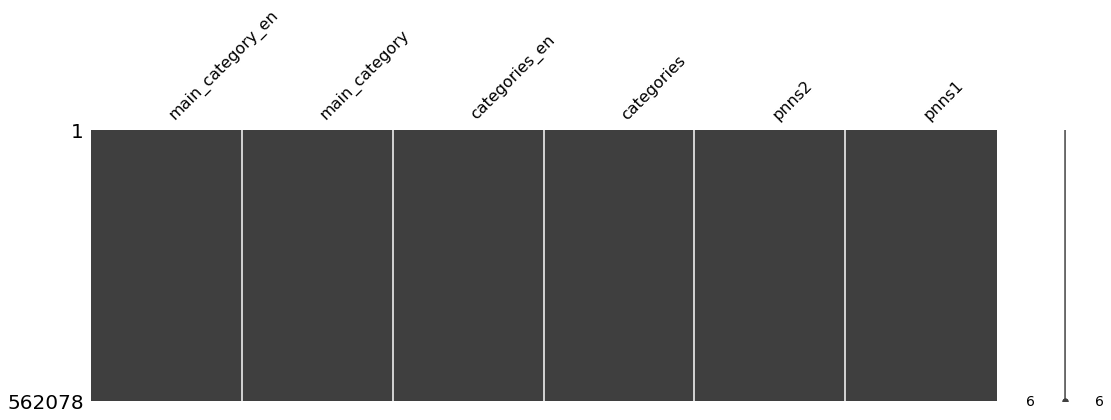

In [10]:
msno.matrix(df[cat_cols])
plt.gcf().set_size_inches(18,5)

In [0]:
msno.matrix(df[sel_cols+cat_cols])
plt.gcf().set_size_inches(8,3)

## 1 Univariate analysis

### Histograms

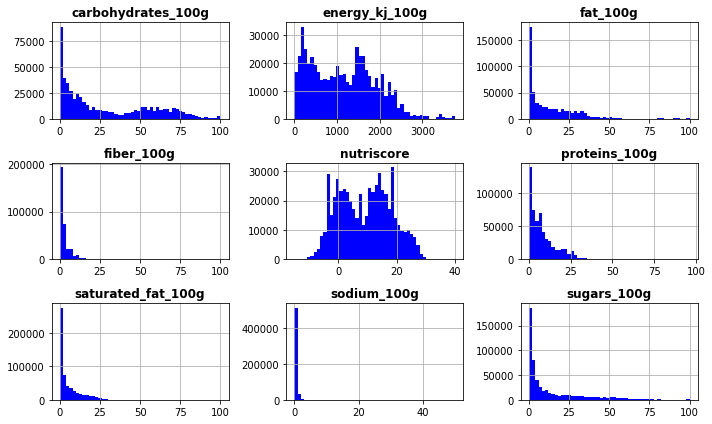

In [32]:
# Plotting histograms of the main quantitative continuous columns
quant_cols = m_nutri_cols+['nutriscore','energy_kj_100g', 'fiber_100g',
                        'sugars_100g', 'saturated_fat_100g']
fig = df[quant_cols].hist(figsize=(10,6), bins=50, color='b',
                        xlabelsize=10, ylabelsize=10);
[x.title.set_fontweight('bold') for x in fig.ravel()];
plt.tight_layout()
#plt.savefig( 'hist.png', format='png', bbox_inches = "tight", dpi=400)

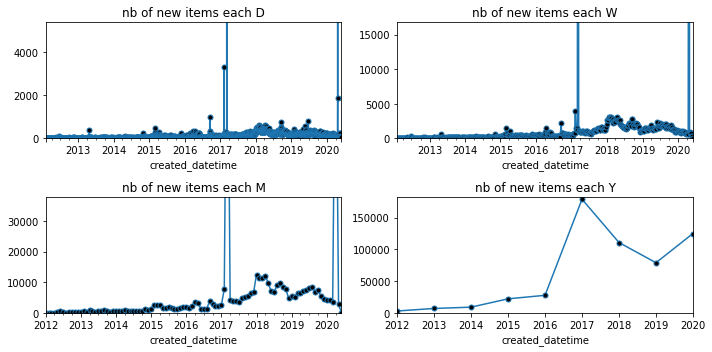

In [20]:
# Plotting number of new items through time
fig = plt.figure(figsize=(10,5))
for i,per in enumerate(['D', 'W', 'M', 'Y'],1):
    ax = fig.add_subplot(2,2,i)
    t_ser = df.groupby(pd.Grouper(key='created_datetime', freq=per)).size()
    t_ser.plot(ax=ax, ms=5, marker='o', mfc='k', ls='-')
    ax.set(ylim=(0,np.mean(t_ser)+2*np.std(t_ser)))
    ax.set_title("nb of new items each "+per)
fig.tight_layout()

In [0]:
# 'quantity_num'

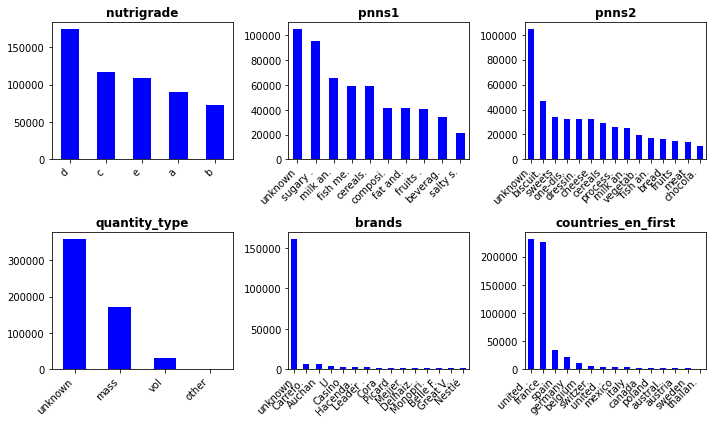

In [30]:
# Plotting bar plots of the main categorical columns
qual_cols = ['nutrigrade','pnns1', 'pnns2',
             'quantity_type', 'brands', 'countries_en_first']
fig = plt.figure(figsize=(10,6))
for i, c in enumerate(qual_cols,1):
    ax = fig.add_subplot(2,3,i)
    df[c].value_counts()[0:15].plot.bar(color='b',ax=ax)
    ax.set_title(c, fontweight='bold')
    labels = [item.get_text() for item in ax.get_xticklabels()]
    short_labels = [s[0:7]+'.' if len(s)>7 else s for s in labels]
    ax.axes.set_xticklabels(short_labels)
    plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Boxplots, swarmplots, violinplots, boxenplots

for nutrigrades subsets

In [0]:
nutri_pal = ['#008000', '#78D222', '#FFD700', '#FF8D00' , '#F23824']
# sns.set_palette(nutri_pal)

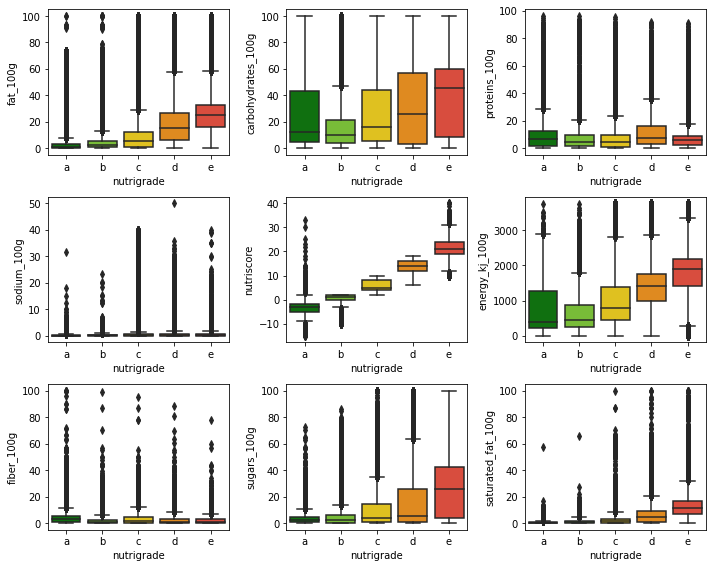

In [34]:
fig = plt.figure(figsize=(10,8))
with sns.color_palette(nutri_pal):
    for i, c in enumerate(quant_cols,1):
        ax = fig.add_subplot(3,3,i) # (len(num_cols)+1)//3, 3
        sns.boxplot(data=df, x='nutrigrade', y=c, order=list('abcde'), ax=ax)
# fig.set_size_inches(12,10)
plt.tight_layout()

for categories subsets

## Bivariate analysis

Correlation in filled/missing values

### Correlation of variables

In [0]:
def plot_heatmap(corr, title, figsize=(8,4), vmin=-1, vmax=1, center=0,
                 palette = sns.color_palette("coolwarm", 20)):
    fig, ax = plt.subplots(figsize=figsize)
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    palette = palette
    ax = sns.heatmap(corr, mask=mask, cmap=palette, vmin=vmin, vmax=vmax,
                     center=center, annot=True, annot_kws={"size": 10}, fmt ='.2f',
                     square=False, linewidths=.5, linecolor = 'white',
                     cbar_kws={"shrink": .9, 'label': None},
                     xticklabels= corr.index, yticklabels = corr.columns)
    ax.tick_params(labelsize=10,top=False, bottom=True,
                labeltop=False, labelbottom=True)
    ax.collections[0].colorbar.ax.tick_params(labelsize=10)
    plt.setp(ax.get_xticklabels(), rotation=25, ha="right",rotation_mode="anchor")
    ax.set_title(title, fontweight='bold', fontsize=12)
    plt.show()

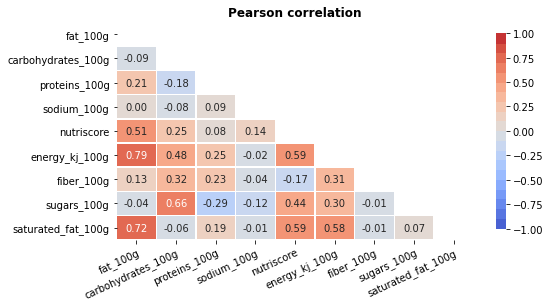

In [36]:
# Linear correlation (Pearson)
pears_corr = df[quant_cols].corr()
plot_heatmap(pears_corr, title="Pearson correlation", figsize=(8,4))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in 

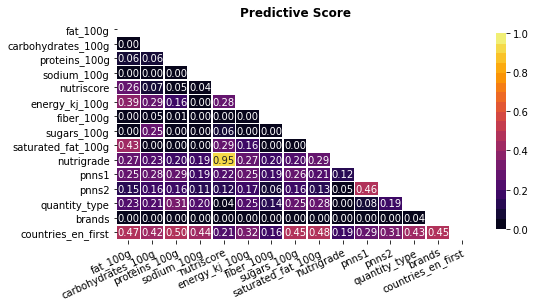

In [41]:
# Predictive Power Score (ppscore)
pps_corr = pps.matrix(df[quant_cols+qual_cols])
plot_heatmap(pps_corr, title="Predictive Score", 
             vmin=0, center=0.5, figsize=(8,4),
             palette=sns.color_palette("inferno", 20))

Pair plots

In [38]:
cols = ['fat_100g', 'nutriscore','proteins_100g','carbohydrates_100g']
# Scatterplot matrix (too much data -> on a sample)
df_sample = df.sample(1000)

# def testcorr(x, y, **kwargs):
#     coef = np.corrcoef(x, y)[0][1]
#     plt.gca().annotate(r'$\rho$ = fffffff' + str(round(coef, 2)),
#                        size = 15, xycoords = ax.transAxes, xy = (-0.1, -0.1)

grid = sns.PairGrid(data=df_test,
                    vars=cols, height=2.5)
grid = grid.map_upper(plt.scatter, marker='o', edgecolors='darkred',
                      alpha=0.5, color='red', s=20)
# grid = grid.map_upper(testcorr)
grid = grid.map_diag(plt.hist, bins = 20, color = 'darkred', edgecolor = 'k')
grid = grid.map_lower(sns.kdeplot, cmap = 'Reds')

#cols = ['fat_100g', 'nutriscore','proteins_100g','carbohydrates_100g']
# 1000 => CPU times: user 9.03 s, sys: 292 ms, total: 9.32 s Wall time: 9 s
# 10000 => CPU times: user 42.9 s, sys: 318 ms, total: 43.2 s Wall time: 42.9 s
# 100000 => CPU times: user 6min 40s, sys: 3.93 s, total: 6min 44s Wall time: 6min 44s

NameError: ignored

## Statistical tests

#### Correlation

ANOVA

Normality Test

## Multivariable analysis

In [0]:
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None, n_cols=3):
    n_rows = (n_comp+1)//n_cols
    fig = plt.figure(figsize=(16,n_rows*3))
    # boucle sur les plans factoriels (3 premiers plans -> 6 composantes)
    for i, (d1, d2) in enumerate(axis_ranks): 
        if d2 < n_comp:
            ax = fig.add_subplot(n_rows, n_cols, i+1)
            # limites
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])
            # flèches, si plus de 30, pas de pointes
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], angles='xy', scale_units='xy', scale=1, color="grey")
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, alpha=.1, color='black'))
            # noms de variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        ax.text(x, y, labels[i], fontsize='14', ha='center', va='center',
                                rotation=label_rotation, color="blue", alpha=0.5)
            # cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            ax.add_artist(circle)
            # définition des limites du graphique
            ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax))
            # affichage des lignes horizontales et verticales
            ax.plot([-1, 1], [0, 0], color='grey', ls='--')
            ax.plot([0, 0], [-1, 1], color='grey', ls='--')
            # nom des axes, avec le pourcentage d'inertie expliqué
            ax.set_xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            ax.set_ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))
            ax.set_title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
    plt.tight_layout()
    plt.show()

In [0]:
def display_factorial_planes(X_proj, n_comp, pca, axis_ranks, labels=None,
                             alpha=1, n_cols=3, illus_var=None, lab_on=True, size=10):
    n_rows = (n_comp+1)//n_cols
    fig = plt.figure(figsize=(16,n_rows*3))
    # boucle sur chaque plan factoriel
    for i, (d1,d2) in (enumerate(axis_ranks)):
        if d2 < n_comp:
            ax = fig.add_subplot(n_rows, n_cols, i+1)
            # points
            if illus_var is None:
                ax.scatter(X_proj[:, d1], X_proj[:, d2], alpha=alpha, s=size)
            else:
                illus_var = np.array(illus_var)
                for value in np.unique(illus_var):
                    sel = np.where(illus_var == value)
                    ax.scatter(X_proj[sel, d1], X_proj[sel, d2], 
                                alpha=alpha, label=value)
                ax.legend()
            # labels points
            if labels is not None and lab_on:
                for i,(x,y) in enumerate(X_proj[:,[d1,d2]]):
                    ax.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center')   
            # limites
            bound = np.max(np.abs(X_proj[:, [d1,d2]])) * 1.1
            ax.set(xlim=(-bound,bound), ylim=(-bound,bound))
            # lignes horizontales et verticales
            ax.plot([-100, 100], [0, 0], color='grey', ls='--')
            ax.plot([0, 0], [-100, 100], color='grey', ls='--')
            # nom des axes, avec le pourcentage d'inertie expliqué
            ax.set_xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            ax.set_ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))
            ax.set_title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
    plt.tight_layout()
    plt.show()

In [0]:
def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show()

In [0]:
# Feature selection for PCA
id = df['code']
cols = ['fat_100g', 'nutriscore','proteins_100g','carbohydrates_100g']

# Imputation of missing values
print('-----missing values imputation-----')
display(df[cols].isna().sum())
X = df[cols].fillna(df.mean()).values

# Data standardisation
print('-----satandardisation----- \n')
X_sc = StandardScaler().fit_transform(X)
print(X[:3],np.array([[x.round(2) for x in li_x] for li_x in X_sc[:3]]), sep='\n')

# Principal components calculation
n = 6
pca = PCA(n_components=n).fit(X_sc) 

print("\n-----explained variance ratio-----\n")
print(pca.explained_variance_ratio_) # ratio d'inertie de chaque composante

print('\n-----coefficients of principal components (origianl features)-----\n')
print(pca.components_)
 
print('\n-----data projected in new space-----\n')
print(pca.transform(X_sc))

-----missing values imputation-----


fat_100g              5789
nutriscore               0
proteins_100g         5783
carbohydrates_100g    6079
dtype: int64

In [0]:
# Eboulis des valeurs propres
display_scree_plot(pca)

In [0]:
# Cercle des corrélations
display_circles(pca.components_, n, pca, [(0,1),(2,3),(4,5)], labels = np.array(var_names), n_cols=3)

In [0]:
# Projection des individus sur les plans d'origine
fig = plt.figure(figsize=(16,6))
for i, (d1,d2) in (enumerate([(0,1),(2,3),(4,5),(6,7)])):
    ax = fig.add_subplot (2, 3, i+1)
    ax.scatter(X_sc[:, d1], X_sc[:, d2], alpha=0.5, s=10)

In [0]:
# Projection des individus sur le plan factoriel
display_factorial_planes(pca.transform(X_sc), n, pca, [(0,1),(2,3),(4,5)],
                         labels = np.array(id_cours), n_cols=3, lab_on=False)

In [0]:
from mlxtend.data import iris_data
from mlxtend.plotting import plot_pca_correlation_graph

ImportError: ignored

In [0]:
from mlxtend.data import iris_data
from mlxtend.plotting import plot_pca_correlation_graph

figure, correlation_matrix = plot_pca_correlation_graph(X_sc, cols,
                                                        dimensions=(1, 2),
                                                        figure_axis_size=10)#, X_pca, explained_variance)

In [0]:
correlation_matrix

#### KMeans Clustering

In [0]:
df = pd.read_csv('./Dataset 1/my_courses.csv', index_col=0)
print(df.shape[0])
X = df.fillna(df.mean()).values
X_sc = StandardScaler().fit_transform(X)

In [0]:
n_clust = 6
km = KMeans(n_clusters=n_clust).fit(X_sc)

In [0]:
# Récupération des clusters attribués à chaque individu
clustK = km.labels_
df['cluster_Kmeans'] = clustK
clustK

In [0]:
# Projection des individus sur le plan factoriel
pca = PCA(n_components=4).fit(X_sc)
X_proj = pca.transform(X_sc)
display_factorial_planes(X_proj, 4, pca,
                         [(0,1),(2,3),(4,5)], labels=np.array(df.index),
                         illus_var = clust.astype(np.float), alpha=0.3, n_cols=3, lab_on=False, size=10)

In [0]:
# Affichage des clusters
for n, s_df in df.groupby('cluster_Kmeans'):
    display(s_df)

#### Hierarchical clustering

In [0]:
# Clustering hiérarchique
Z = linkage(X_sc, 'ward')
Z[0:15]

In [0]:
plt.figure(figsize=(16,10))
dendrogram(Z, labels = df.index, orientation = "right", count_sort='descending')
plt.show()

In [0]:
# Coupage du dendrogramme
n_clust = 6
clustH = fcluster(Z, n_clust, criterion='maxclust')
df['cluster_HierClust'] = clustH
clustH

In [0]:
# Affichage des clusters
for n, s_df in df.groupby('cluster_HierClust'):
    display(s_df)